<h1 style="text-align: center;">
    Trabajo Práctico
</h1>

<h2 style="text-align: center;">
    Sistema de Recomendación para Elaboración de Cerveza
</h2>

<h3 style="text-align: center;">
    Sistemas Automáticos de Diagnóstico y Detección de Fallas II
</h3>

<div style="display: flex;justify-content: center;align-items: center">
<table>
  <tbody>
    <tr>
      <th><h5 style="text-align: center;">Nombre</h5></th>
      <th><h5 style="text-align: center;">Padrón</h5></th>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Barreneche Franco</h5></td>
      <td><h5 style="text-align: center;">102205</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Botta Guido</h5></td>
      <td><h5 style="text-align: center;">102103</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Carol Lugones Ignacio</h5></td>
      <td><h5 style="text-align: center;">100073</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Pernin Alejandro</h5></td>
      <td><h5 style="text-align: center;">92216</h5></td>
    </tr>
  </tbody>
</table>
</div>

# Importación de bibliotecas

In [1]:
import numpy as np
import pandas as pd
from copy import copy
import random
import os                                                 
import sys
import itertools
import dowhy
from dowhy import CausalModel
module_path = os.path.abspath(os.path.join('../server'))                                                      
if module_path not in sys.path:                        
    sys.path.append(module_path)                    
from expertSystem.expertSystem import getCandidateBeers
from ydata_profiling import ProfileReport

# Generación de DataSet sintético

In [2]:
INTENSITY_TYPES = ["baja", "media", "alta", "*"]
COLOR_TYPES = ["palido", "ambar", "oscuro", "*"]
BITTERNESS_TYPES = ["bajo", "medio", "alto", "*"]
HOP_TYPES = ["viejo mundo", "nuevo mundo", "*"]
FERMENTATION_TYPES = ["baja", "media", "alta", "*"]
YEAST_TYPES = ["lager", "ale", "*"]
feature_types = {
    'intensity': INTENSITY_TYPES,
    'color': COLOR_TYPES,
    'bitterness': BITTERNESS_TYPES,
    'hop': HOP_TYPES,
    'fermentation': FERMENTATION_TYPES,
    'yeast': YEAST_TYPES,
}
features = list(feature_types.keys())
allOptions = list(itertools.product(*feature_types.values()))
responsesI = []

for x in allOptions:
    d = {
        'intensity': x[0],
        'color': x[1],
        'bitterness': x[2],
        'hop': x[3],
        'fermentation': x[4],
        'yeast': x[5]
    }
    r = getCandidateBeers(d)['candidateBeers']
    if len(r) > 2:
        continue
    if len(r) == 1:
        d['beer'] = r[0]
    else:
        d['beer'] = 'None'
    responsesI.append(d)

In [3]:
result_df = pd.DataFrame(responsesI)
result_df.head(10)

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,baja,palido,bajo,viejo mundo,baja,lager,None
1,baja,palido,bajo,viejo mundo,baja,ale,None
2,baja,palido,bajo,viejo mundo,baja,*,None
3,baja,palido,bajo,viejo mundo,media,lager,None
4,baja,palido,bajo,viejo mundo,media,ale,None
5,baja,palido,bajo,viejo mundo,media,*,None
6,baja,palido,bajo,viejo mundo,alta,lager,None
7,baja,palido,bajo,viejo mundo,alta,ale,None
8,baja,palido,bajo,viejo mundo,alta,*,None
9,baja,palido,bajo,viejo mundo,*,lager,None


In [4]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   intensity     2290 non-null   object
 1   color         2290 non-null   object
 2   bitterness    2290 non-null   object
 3   hop           2290 non-null   object
 4   fermentation  2290 non-null   object
 5   yeast         2290 non-null   object
 6   beer          2290 non-null   object
dtypes: object(7)
memory usage: 125.4+ KB


Dada la simpleza del modelo, para la generación del dataset sintético se iteran todas las combinaciones de atributos posibles y se envía al backend del sistema. No se aprovecha ninguna característica del sistema en sí, como ser la determinación de la mejor pregunta siguiente, sino que se toma el resultado de aplicar las reglas tal y como se definen en el negocio. Se tienen 2304 combinaciones posibles, de las cuales se descartan las 14 que corresponderían a pasos intermedios, es decir, que arrojan más de una cerveza candidata.

# Profiling de dataset

In [5]:
ProfileReport(result_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Se generó un dataset con todas las combinaciones posibles de preferencias del usuario, incluyendo que el usuario opte por 'indistinto'; para cada conjunto de preferencias se empleó el motor de reglas para obtener la clase de cerveza a recomendar. La combinación arrojó 2290 combinaciones posibles, de las cuales 1888 no arrojan resultado de cerveza a recomendar; esto se debe a que nuestro conjunto de reglas es acotado y específico, lo cuál limita el universo de preferencias que puede abarcar. Desde una perspectiva comercial, se podria considerar que estos resultados representan un mercado disponible aún no explotado y que de proveer un conjunto de reglas más extenso, podriamos satisfacer la demanda de más clientes

En cuanto a la correlación de los datos, no existe entre características, pero si entre características y la cerveza resultante. Fermentación e intensidad son particularmente prometedoras, pues están mucho más correlacionadas con el resultado que el resto. Pronto evaluaremos si esta corelación es espúria.

# Análisis de inferencia causal

El primer paso para aplicar las herramientas de análisis provistas es mapear las features a números. Para el caso de intensidad, color u amargor esta correspondencia es trivial, ya que existe una noción de grado o nivel. Para el resto de features categóricas el mapeo es escencialmente arbitrario. Siempre se toma el valor "*" u indeterminado como cero dado que su significado es uniforme para todas las características.

In [6]:
%matplotlib inline

In [7]:
intensity_mapping = {"*":0,"baja":1,"media":2,"alta":3}
color_mapping = {'*': 0, 'palido': 1, 'oscuro': 2, 'ambar': 3}
bitterness_mapping = {"*":0,"bajo":1,"medio":2,"alto":3}
hop_mapping ={"*": 0, "viejo mundo" : 1, "nuevo mundo": 2}
fermentation_mapping = intensity_mapping
yeast_mapping = {"*":0, "lager":1, "ale":2}
beer_mapping = {'Cream Ale': 0, 'None': 1,'Kolsch': 2, 'Lager Ambar Checa': 3, 'Baltic Porter': 4, 'Ipa Blanca': 5}

result_df = result_df.replace({
    'intensity': intensity_mapping,
    'color': color_mapping,
    'bitterness': bitterness_mapping,
    'hop': hop_mapping,
    'fermentation': fermentation_mapping,
    'yeast': yeast_mapping,
    'beer': beer_mapping
})
result_df

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,1,1,1,1,1,1,1
1,1,1,1,1,1,2,1
2,1,1,1,1,1,0,1
3,1,1,1,1,2,1,1
4,1,1,1,1,2,2,1
...,...,...,...,...,...,...,...
2285,0,0,0,0,2,0,1
2286,0,0,0,0,3,1,1
2287,0,0,0,0,3,2,1
2288,0,0,0,0,3,0,1


In [8]:
def generate_causal_model(target_feature):
    target_df = result_df.copy()
    target_df['treatment'] = result_df[target_feature] != 0
    causal_graph = """digraph {
                        hop;
                        fermentation;
                        yeast;
                        
                        intensity;
                        color;
                        bitterness;
    
                        treatment;
    
                        hop->beer;
                        fermentation->beer;
                        yeast->beer;
                        intensity->beer;
                        color->beer;
                        bitterness->beer;
                        treatment->beer;
                        Z->treatment;
                   """ 
    causal_graph = causal_graph + target_feature + "->treatment;}"
    model = dowhy.CausalModel(data=target_df,
                              graph=causal_graph.replace("\n", " "),
                              treatment="treatment",
                              outcome="beer")
    model.view_model()
    return model

In [9]:
def refute_model(model):
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name='backdoor.propensity_score_matching',
                                     target_units='att')
    refutation = model.refute_estimate(identified_estimand, 
                                       estimate, 
                                       method_name='placebo_treatment_refuter',
                                       placebo_type='permute', 
                                       num_simulations=20)
    return refutation

## Features invididuales

Comenzamos evaluando la contribución individual de cada feature asumiendo que todas tienen la misma importancia. Para ello insertamos la variable Z junto a la característica a comparar y establecemos treatment en True cuando esa característica toma valor y False cuando es indeterminada. 

INTENSITY


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


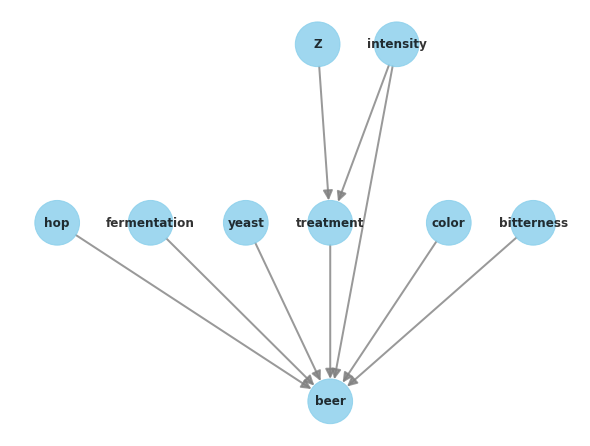

Refute: Use a Placebo Treatment
Estimated effect:0.20579710144927535
New effect:0.26185507246376816
p value:0.05050367544879472

COLOR


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


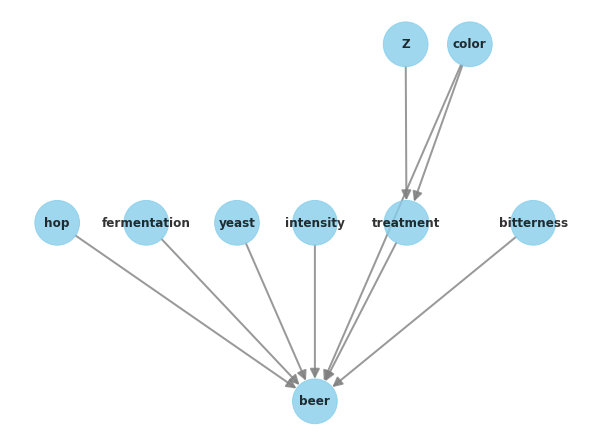

Refute: Use a Placebo Treatment
Estimated effect:0.21345707656612528
New effect:0.29625870069605575
p value:0.0003641708297013223

BITTERNESS


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


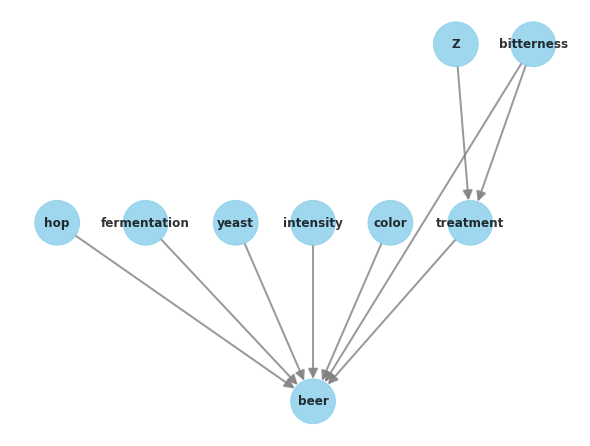

Refute: Use a Placebo Treatment
Estimated effect:0.23197674418604652
New effect:0.30165697674418607
p value:0.00048246039859320823

HOP


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


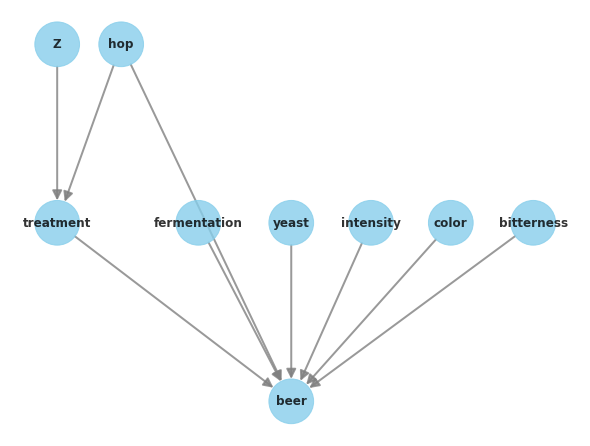

Refute: Use a Placebo Treatment
Estimated effect:0.2151238591916558
New effect:0.4005541069100391
p value:0.02112355800319405

FERMENTATION


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


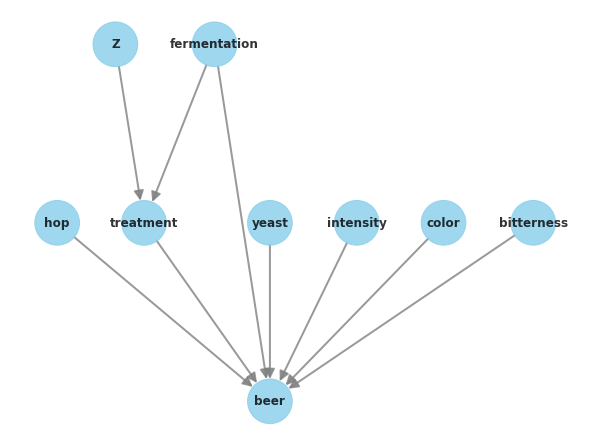

Refute: Use a Placebo Treatment
Estimated effect:0.21064814814814814
New effect:0.32277199074074076
p value:0.0014045387926201647

YEAST


/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


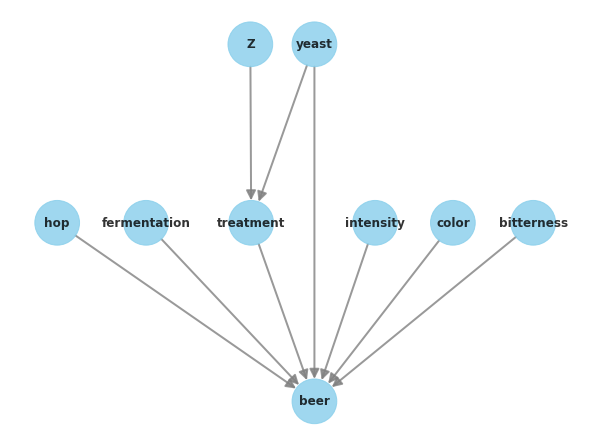

Refute: Use a Placebo Treatment
Estimated effect:0.20887728459530025
New effect:0.34722584856396865
p value:0.008397428811289551



In [10]:
p_values = dict()
for feature in features:
    print(feature.upper())
    model = generate_causal_model(feature)
    refutation = refute_model(model)
    p_values[feature] = refutation.refutation_result['p_value']
    print(refutation)

In [11]:
print("PValues")
l = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}
for k in l.keys():
    print(f"{k.upper():12} {l[k]}")

PValues
COLOR        0.0003641708297013223
BITTERNESS   0.00048246039859320823
FERMENTATION 0.0014045387926201647
YEAST        0.008397428811289551
HOP          0.02112355800319405
INTENSITY    0.05050367544879472


Notamos que los p_valores individuales son muy favorables, a excepción de intensidad, que necesariamente será consecuencia del valor de otras características. A continuación ensayaremos relaciones causales coherentes con lo esperado a partir del trabajo previo con el experto.

## Features jerarquizadas

/Users/luiscarollugones/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


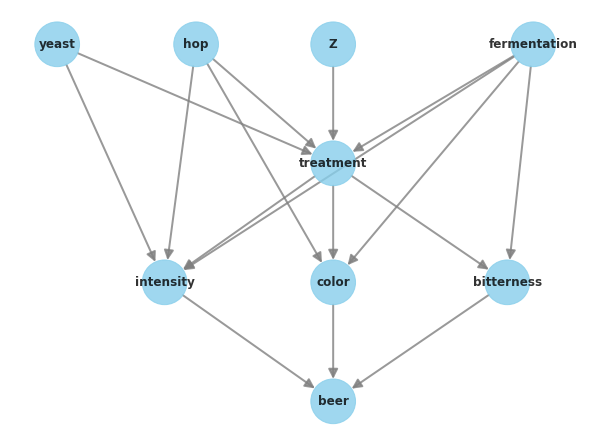

Refute: Use a Placebo Treatment
Estimated effect:0.7161458333333334
New effect:0.31477864583333337
p value:7.0157320297111405e-06



In [12]:
target_df = result_df.copy()
target_df['treatment'] = (target_df['hop'] != 0) & (target_df['fermentation'] != 0) & (target_df['yeast'] != 0)
causal_graph = """digraph {
                    hop;
                    fermentation;
                    yeast;
                    
                    intensity;
                    color;
                    bitterness;

                    treatment;

                    intensity->beer;
                    color->beer;
                    bitterness->beer;
                    
                    Z->treatment;
                    hop->intensity;
                    yeast->intensity;
                    fermentation->intensity;
                    
                    hop->color;
                    fermentation->color;
                    
                    fermentation->bitterness;
                    
                    hop->treatment;
                    yeast->treatment;
                    fermentation->treatment;
                    
                    treatment->bitterness;
                    treatment->color;
                    treatment->intensity;
                }
               """ 
model = dowhy.CausalModel(data=target_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="beer")
model.view_model()
print(refute_model(model))

El modelo con mejor p_valor que encontramos es uno en donde los ingredientes y condiciones de creación de cerveza determinan la características esperables en la cerveza final. La levadura no condiciona el color, pero por otro lado, la fermentación incrementa los azúcares en la cerveza y, por ende, determina casi directamente el amargor/bitternes.

# IA Explainable

Se entrenará un modelo para validar el modelo causal encontrado.

In [13]:
from pycaret.datasets import get_data
from pycaret.classification import *
data = result_df
clf1 = setup(data, target = 'beer', session_id=123)

,Description,Value
0,Session id,123
1,Target,beer
2,Target type,Multiclass
3,Original data shape,"(2290, 7)"
4,Transformed data shape,"(2290, 7)"
5,Transformed train set shape,"(1603, 7)"
6,Transformed test set shape,"(687, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [14]:
# Se congela tras evaluar los primeros modelos
# best_model = compare_models()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9389,0.9138,0.9389,0.9435,0.9405,0.8104,0.8111


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

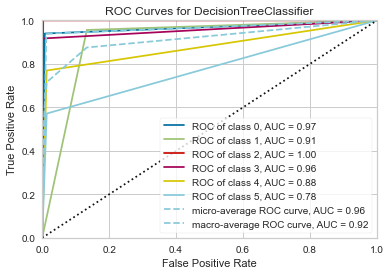

In [15]:
analysis_model = create_model('dt', cross_validation=False)
plot_model(analysis_model)

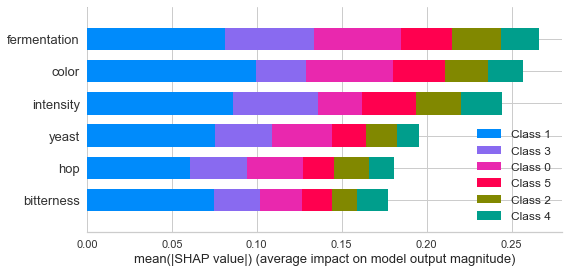

In [16]:
interpret_model(analysis_model)

El resultado del score SHAP se ciñe al modelo causal planteado. Color e intensidad determinan directamente cerveza, por lo que es razonable que presenten un valor alto. Bitterness no esperaríamos que puntúe tan bajo, pero fermentación la determina casi por completo y, además, permite obtener información del color y la intensidad, por lo que puede interpretarse que la ha reemplazado. Más allá de la leve discrepancia el modelo se ve confirmado por otra vía.

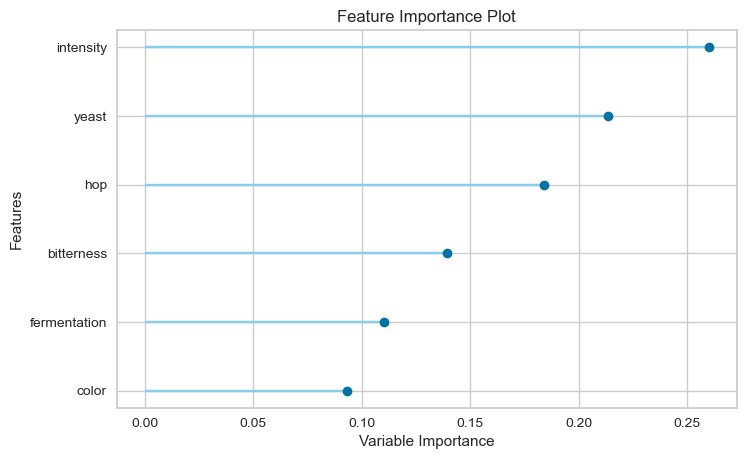

In [17]:
plot_model(analysis_model, plot = 'feature')

El gráfico de importancia de variable contradice al modelo SHAP, y no logramos encontrar sentido a la relación de sus resultados. Creemos que presenta un sesgo por el reducido tamaño del dominio, al menos frente a SHAP, que es un método en donde se evalúan distitnas clases y no se ve afectado en tal medida de la estructura del árbol de decisión. 

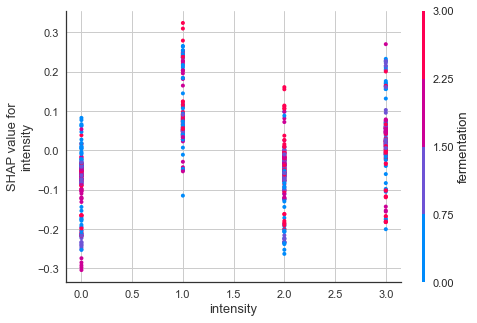

In [18]:
interpret_model(analysis_model, plot = 'correlation')

Las correlaciones en cada valor entre intensidad y fermentación varían en gran medida en cada valor y se encuentran centradas o balanceadas. Si existe la correlación será espúrea, ya que como se observó en el profiling, no se presenta realmente vínculo causal directo entre ellas, más allá de que a grandes rasgos una bebida más fermentada tiene mayor intensidad alcohólica, pero la realidad de la destilación es bastante más compleja.

# Conclusión

Hemos utilizado herramientas de analisis de inferencia causal y puesto a prueba nuestro entendimiento del modelo. Aunque ha requerido de un trabajo iterativo, estamos conformes con el detalle alcanzado.